**1. Using XgBoost**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap


In [23]:
#Step 2: Load Dataset
file_path = '/content/drive/MyDrive/events.csv'  # Update with your uploaded file's path if needed
data = pd.read_csv(file_path)
print("Dataset Loaded. Shape:", data.shape)
data.head()

Dataset Loaded. Shape: (885129, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [24]:
#Step 3:Exploratory Data Analysis (EDA)
#Inspect missing values
print("Missing Values per Column:\n", data.isnull().sum())


Missing Values per Column:
 event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64


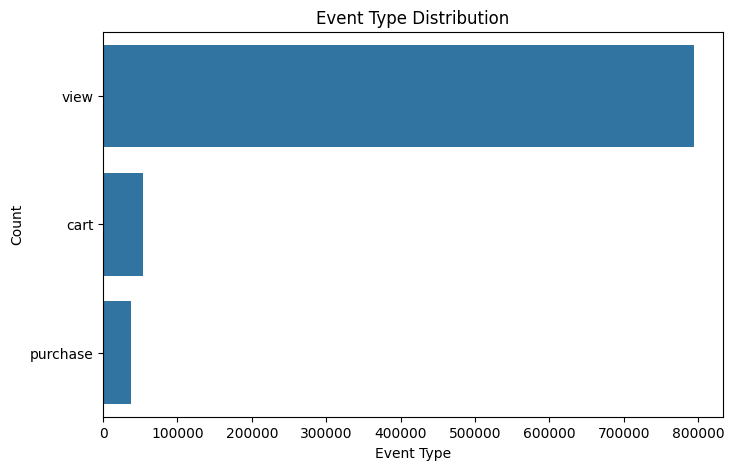

In [25]:
# Event type distribution
plt.figure(figsize=(8, 5))
sns.countplot(data['event_type'], order=data['event_type'].value_counts().index)
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

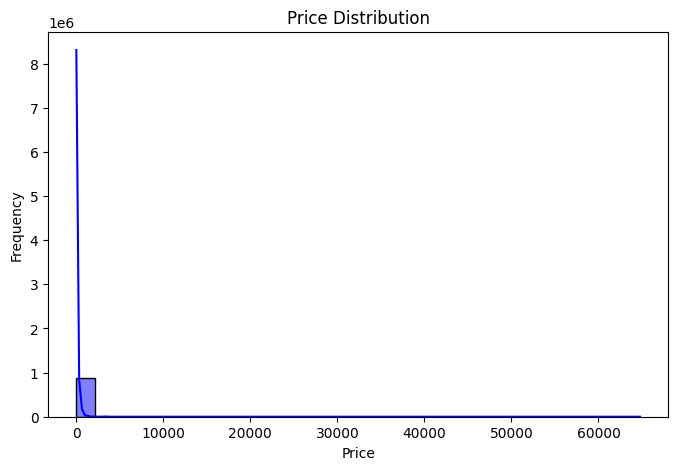

In [26]:
# Price distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['price'], kde=True, bins=30, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [27]:
#Unique users and sessions
unique_users = data['user_id'].nunique()
unique_sessions = data['user_session'].nunique()
print(f"Unique Users: {unique_users}")
print(f"Unique Sessions: {unique_sessions}")

Unique Users: 407283
Unique Sessions: 490398


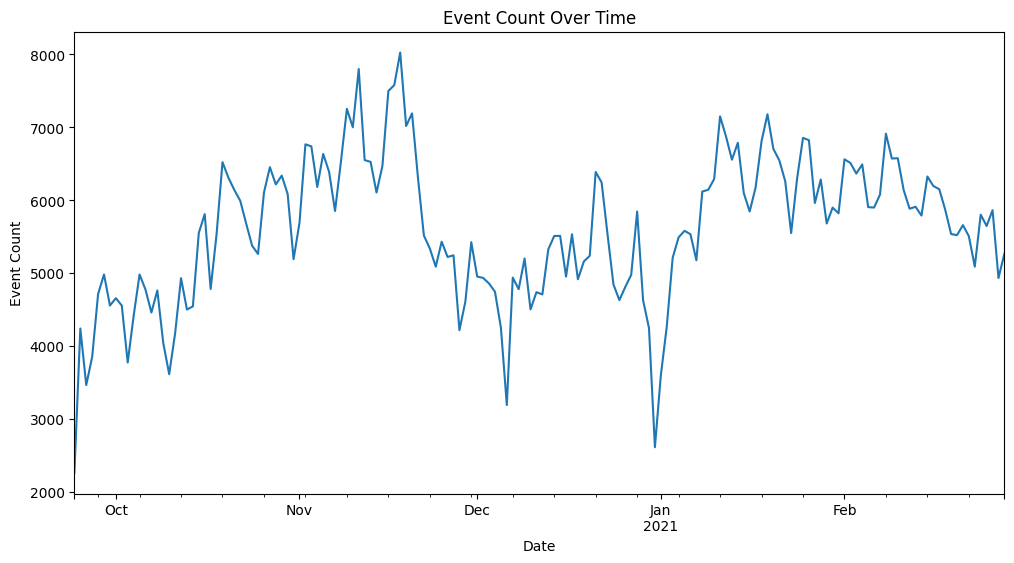

In [28]:
#Event over time
plt.figure(figsize=(12, 6))
data['event_time'] = pd.to_datetime(data['event_time'])
data.set_index('event_time')['event_type'].resample('D').count().plot()
plt.title('Event Count Over Time')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.show()


In [29]:
#Step 4: Define Churn
#Define churned users as those with no activity in the last 30 days
data['days_since_last_event'] = (data['event_time'].max() - data['event_time']).dt.days

churn_threshold = 30
user_last_activity = data.groupby('user_id')['days_since_last_event'].min()
churned_users = user_last_activity[user_last_activity > churn_threshold].index

data['churned'] = data['user_id'].apply(lambda x: 1 if x in churned_users else 0)


In [30]:
#Step 5: Feature Engineering
#user-level features
user_features = data.groupby('user_id').agg({
    'event_time': ['max', 'min', 'nunique'],
    'event_type': lambda x: (x == 'purchase').sum(),
    'price': ['sum', 'mean'],
    'user_session': 'nunique'
})

#Flatten column names
user_features.columns = ['_'.join(col).strip() for col in user_features.columns]
user_features.reset_index(inplace=True)

#Add churn label
user_features = user_features.merge(data[['user_id', 'churned']].drop_duplicates(), on='user_id', how='left')


In [32]:
#Step 6: Data Preprocessing
#Encode categorical features and scale numerical features
encoder = LabelEncoder()
scaler = StandardScaler()

user_features['event_time_max'] = user_features['event_time_max'].astype('int64')
user_features['event_time_min'] = user_features['event_time_min'].astype('int64')

X = user_features.drop(['user_id', 'churned'], axis=1)
X_scaled = scaler.fit_transform(X)
y = user_features['churned']


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Gradient Boosting Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1       1.00      1.00      1.00     97621

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

AUC-ROC Score: 1.0

Logistic Regression Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1       1.00      1.00      1.00     97621

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

AUC-ROC Score: 0.9999989099077742

XGBoost Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1

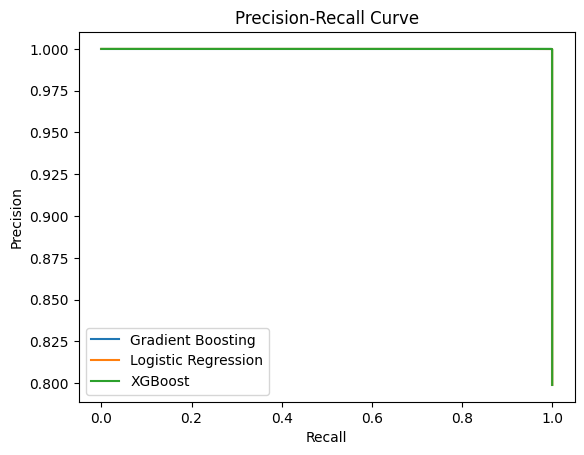

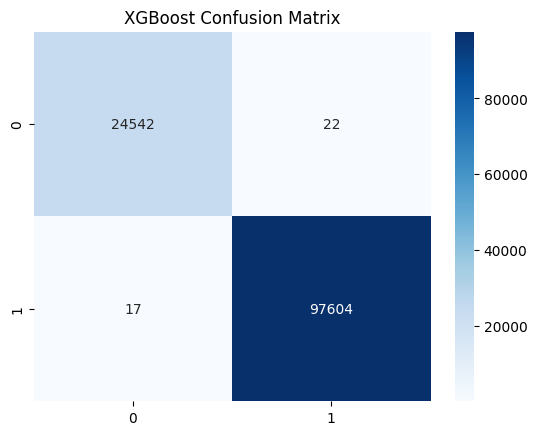

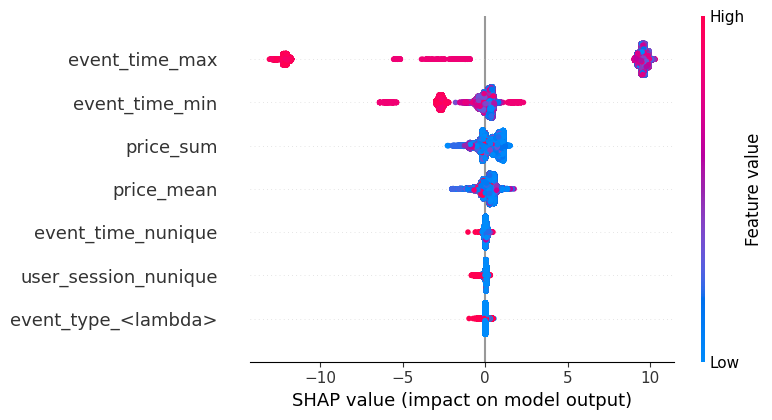

Analysis complete. Consider the SHAP summary plot for feature importance insights.


In [33]:
#Step 7: Model Building
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

#Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

#XGBoost Model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

#Step 8: Model Evaluation
models = {
    "Gradient Boosting": gb_model,
    "Logistic Regression": lr_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    print(f"\n{name} Model Evaluation")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    print("Classification Report:\n", classification_report(y_test, y_pred))
    if y_proba is not None:
        print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=name)

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Confusion Matrix for XGBoost
sns.heatmap(confusion_matrix(y_test, xgb_model.predict(X_test)), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

#Step 9: Interpretability
#SHAP values for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)

#Step 10: Business Recommendations
print("Analysis complete. Consider the SHAP summary plot for feature importance insights.")


**2. Whole code of XgBoost in 1 cell**

Dataset Loaded. Shape: (885129, 9)
Missing Values per Column:
 event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64


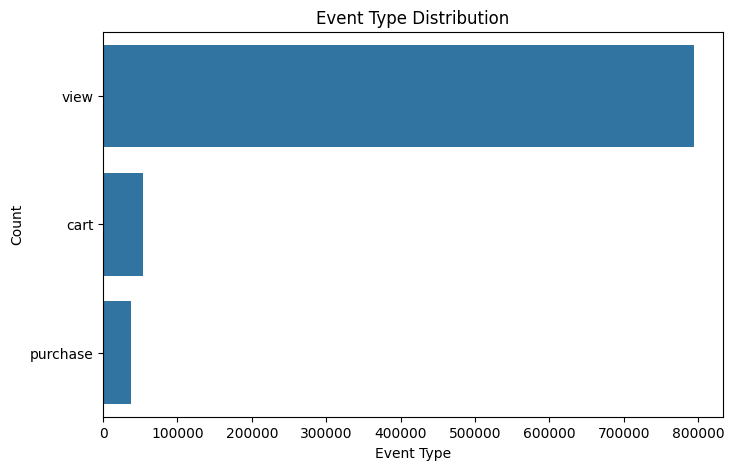

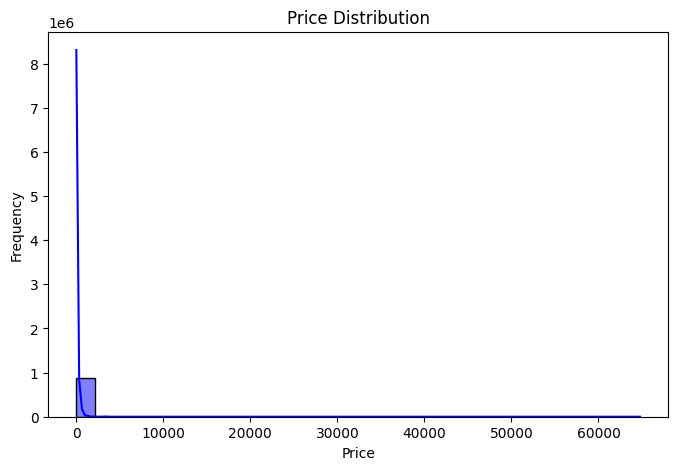

Unique Users: 407283
Unique Sessions: 490398


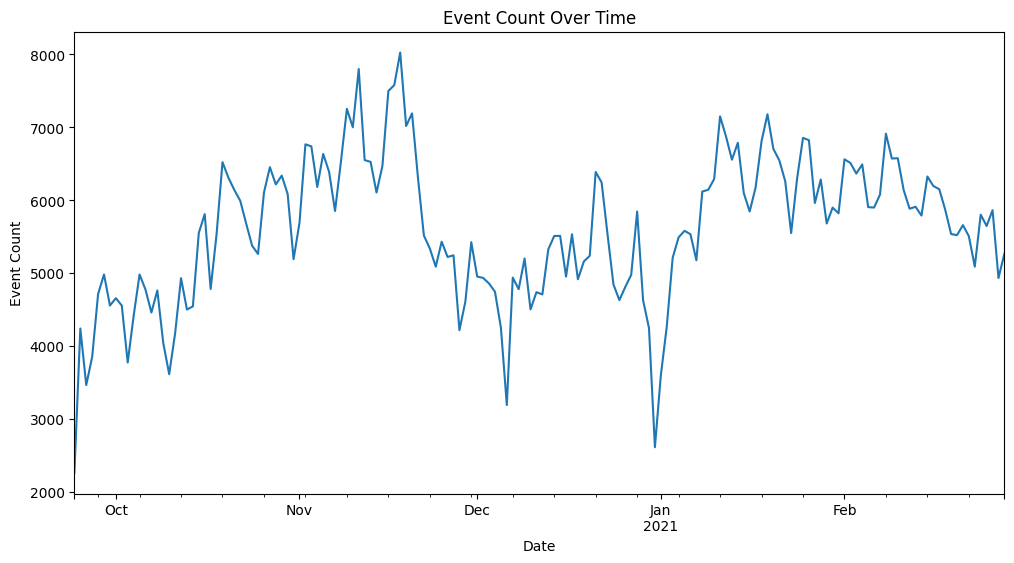

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Gradient Boosting Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1       1.00      1.00      1.00     97621

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

AUC-ROC Score: 1.0

Logistic Regression Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1       1.00      1.00      1.00     97621

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

AUC-ROC Score: 0.9999989099077742

XGBoost Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1

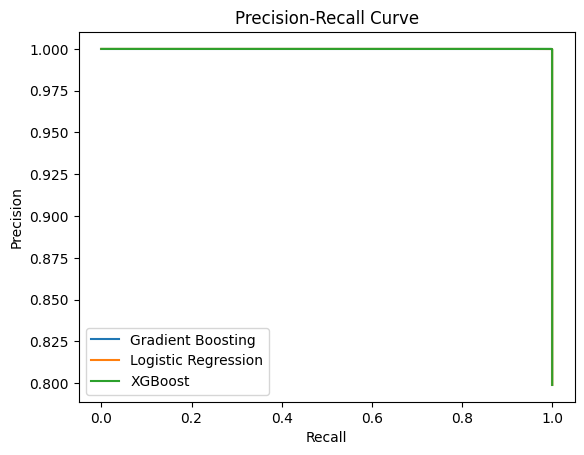

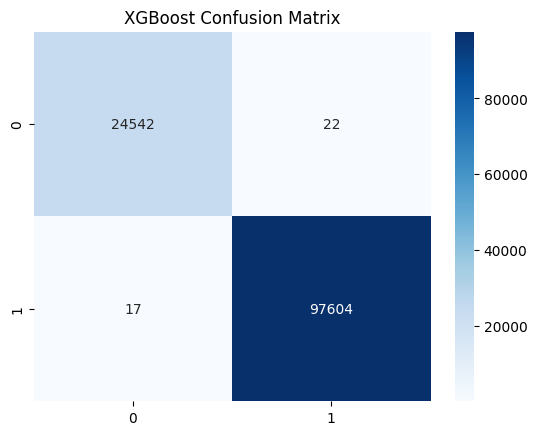

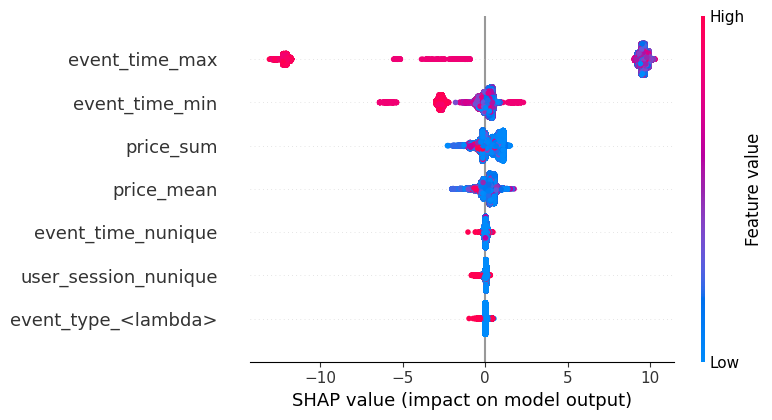

Analysis complete. Consider the SHAP summary plot for feature importance insights.


In [34]:
#Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap

#Step 2: Load Dataset
file_path = '/content/drive/MyDrive/events.csv'
data = pd.read_csv(file_path)
print("Dataset Loaded. Shape:", data.shape)
data.head()

#Step 3: Exploratory Data Analysis (EDA)
#Inspect missing values
print("Missing Values per Column:\n", data.isnull().sum())

#Event type distribution
plt.figure(figsize=(8, 5))
sns.countplot(data['event_type'], order=data['event_type'].value_counts().index)
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

#Price distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['price'], kde=True, bins=30, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#Unique users and sessions
unique_users = data['user_id'].nunique()
unique_sessions = data['user_session'].nunique()
print(f"Unique Users: {unique_users}")
print(f"Unique Sessions: {unique_sessions}")

#Event over time
plt.figure(figsize=(12, 6))
data['event_time'] = pd.to_datetime(data['event_time'])
data.set_index('event_time')['event_type'].resample('D').count().plot()
plt.title('Event Count Over Time')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.show()

#Step 4: Define Churn
#Define churned users as those with no activity in the last 30 days
data['days_since_last_event'] = (data['event_time'].max() - data['event_time']).dt.days
churn_threshold = 30
user_last_activity = data.groupby('user_id')['days_since_last_event'].min()
churned_users = user_last_activity[user_last_activity > churn_threshold].index

data['churned'] = data['user_id'].apply(lambda x: 1 if x in churned_users else 0)

#Step 5: Feature Engineering
#user-level features
user_features = data.groupby('user_id').agg({
    'event_time': ['max', 'min', 'nunique'],
    'event_type': lambda x: (x == 'purchase').sum(),
    'price': ['sum', 'mean'],
    'user_session': 'nunique'
})

#Flatten column names
user_features.columns = ['_'.join(col).strip() for col in user_features.columns]
user_features.reset_index(inplace=True)

#Add churn label
user_features = user_features.merge(data[['user_id', 'churned']].drop_duplicates(), on='user_id', how='left')

#Step 6: Data Preprocessing
#Encode categorical features and scale numerical features
encoder = LabelEncoder()
scaler = StandardScaler()

user_features['event_time_max'] = user_features['event_time_max'].astype('int64')
user_features['event_time_min'] = user_features['event_time_min'].astype('int64')

X = user_features.drop(['user_id', 'churned'], axis=1)
X_scaled = scaler.fit_transform(X)
y = user_features['churned']

#Step 7: Model Building
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

#Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

#XGBoost Model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

#Step 8: Model Evaluation
models = {
    "Gradient Boosting": gb_model,
    "Logistic Regression": lr_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    print(f"\n{name} Model Evaluation")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    print("Classification Report:\n", classification_report(y_test, y_pred))
    if y_proba is not None:
        print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=name)

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Confusion Matrix for XGBoost
sns.heatmap(confusion_matrix(y_test, xgb_model.predict(X_test)), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

#Step 9: Interpretability
# SHAP values for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)

#Step 10: Business Recommendations
print("Analysis complete. Consider the SHAP summary plot for feature importance insights.")


**3. Performance Comparison between different Machine Learning Models**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Gradient Boosting Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1       1.00      1.00      1.00     97621

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

AUC-ROC Score: 1.0

Logistic Regression Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1       1.00      1.00      1.00     97621

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

AUC-ROC Score: 0.9999989099077742

XGBoost Model Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24564
           1

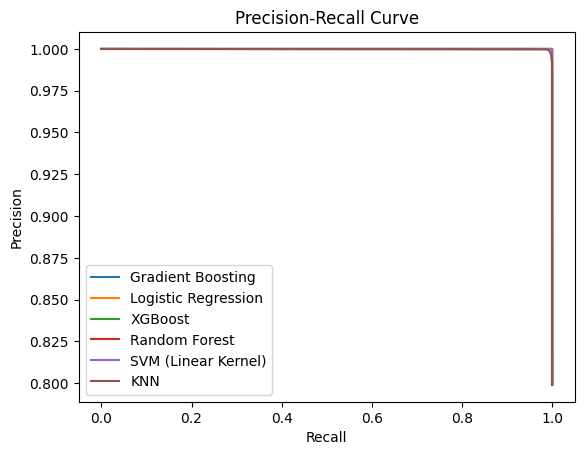


Consolidated Model Performance:
                  Model  Accuracy   AUC-ROC  Precision    Recall  F1-Score
0    Gradient Boosting  1.000000  1.000000   1.000000  1.000000  1.000000
1  Logistic Regression  0.999844  0.999999   0.999845  0.999844  0.999844
2              XGBoost  0.999681  0.999999   0.999681  0.999681  0.999681
3        Random Forest  1.000000  1.000000   1.000000  1.000000  1.000000
4  SVM (Linear Kernel)  0.999844  0.999999   0.999845  0.999844  0.999844
5                  KNN  0.994950  0.999268   0.994944  0.994950  0.994946


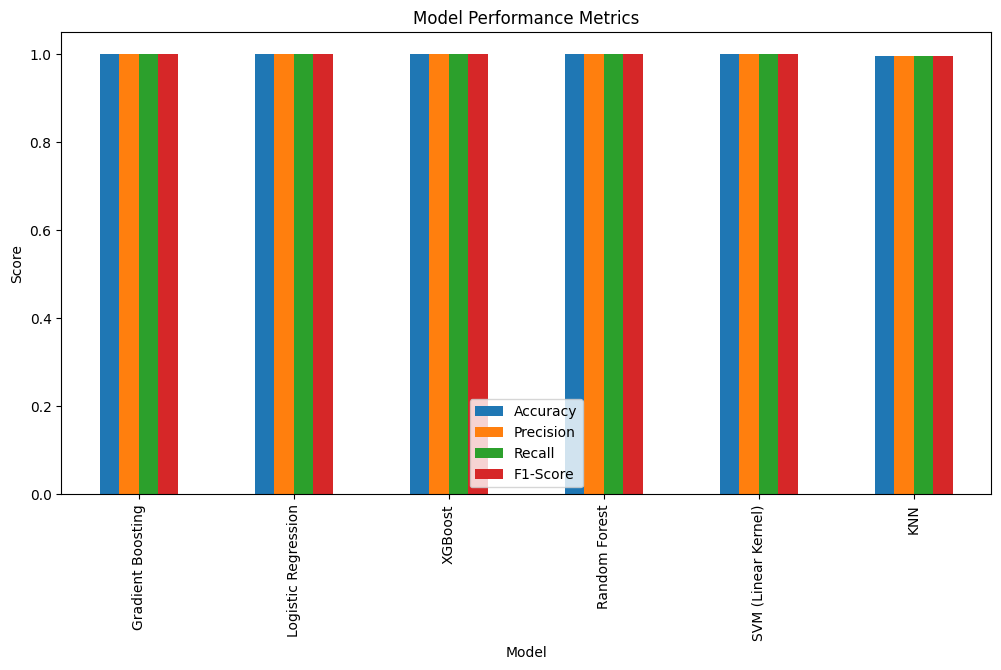

In [35]:
#Import Libraries for New Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Step 7(Updated):Train Models
models = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

#Train all models
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

#Step 8(Updated):Evaluate Models
results = []
for name, model in trained_models.items():
    print(f"\n{name} Model Evaluation")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    classification = classification_report(y_test, y_pred, output_dict=True)
    accuracy = classification['accuracy']
    auc_roc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
    precision = classification['weighted avg']['precision']
    recall = classification['weighted avg']['recall']
    f1_score = classification['weighted avg']['f1-score']

    print("Classification Report:\n", classification_report(y_test, y_pred))
    if y_proba is not None:
        print("AUC-ROC Score:", auc_roc)

        #Precision-Recall Curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall_curve, precision_curve, label=name)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC-ROC": auc_roc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    })

#Precision-Recall Curve Plot
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#Step 9(Updated):Consolidated Results
results_df = pd.DataFrame(results)
print("\nConsolidated Model Performance:\n", results_df)

#Visualization of Results
results_df.set_index("Model", inplace=True)
results_df.drop("AUC-ROC", axis=1, inplace=True, errors="ignore")
results_df.plot(kind='bar', figsize=(12, 6), title="Model Performance Metrics")
plt.ylabel("Score")
plt.show()
